# EXPLANATION OF THIS TASK

In this question you will implement and compare the following different KNN variants:

1.   Naive KNN
2.   LSH
3.   KD-Tree

Vary dataset size $N$, number of dimensions $d$ to do training and testing time and memory comparison for finding $K$ nearest neighbours.

Now, in a 2D randomly generated dataset visually show how many of the $K$ closest neighbors approximate KNN methods miss out on due to their approximate nature.

Also show the partitions in the 2D space.


Procedure: We created multiple datasets with varying values of $N$, the number of data points, and $d$, the number of dimensions. We then split this generated data into train and test data. The test data points were input as queries to each of the three methods and the computational time and memory usage for each algorithm were calculated and compared.

# IMPORTING RELEVANT LIBRARIES AND CREATING DATASETS

In [41]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # to get sharper graphics
import math
import time
from tabulate import tabulate
from itertools import product
import tracemalloc

In [42]:
datasets = {} # creating a dictionary to store different datasets
N_vals = [100, 1000, 10000] # varying the values of number of datapoints
d_vals = [2, 4, 8] # varying values of number of dimensions
for N in N_vals: # N is the number of points in the dataset
  for d in d_vals: # d is the number of dimensions
    datasets[(N, d)] = np.random.randn(N, d) # key is the tuple (N, d) and value is the dataset

In [43]:
queries = {key: np.random.randn(10, key[1]) for key in datasets.keys()}

# NAIVE KNN

In [44]:
def Naive_KNN(d_train,d_test,k):
  times=[]
  d_nn={}
  for i in range(len(d_test)):
    t1=time.time()
    pt_dist={}
    test_pt=d_test[i]
    train=d_train
    dists=np.linalg.norm(train-test_pt,axis=1)
    sorted_dists = np.argsort(dists)[:k] # To get the indices of k shortest distances.
    for j in range(k):
      idx=sorted_dists[j]
      pt_dist[dists[idx]]=d_train[idx]
    d_nn[tuple(test_pt)]=pt_dist
    t2=time.time()
    times.append(t2-t1)
  return d_nn,times

In [95]:
def print_knn_tables(d_nn):
    for test_pt, neighbors in d_nn.items():
        table_data = []

        for i, (dist, coords) in enumerate(sorted(neighbors.items()), start=1):
            table_data.append([f"Neighbor {i}", f"{dist:.4f}", np.array2string(coords, formatter={'float_kind': lambda x: f"{x:.4f}"})])

        test_pt_str = np.array2string(np.array(test_pt), formatter={'float_kind': lambda x: f'{x:.4f}'})
        print(f"\nTest Point: {test_pt_str}")

        print(tabulate(           #tabulate for prettier tables.
            table_data,
            headers=["Nearest Neighbor", "Distance", "Coordinates"],
            tablefmt="fancy_grid",
            stralign="center",
            numalign="center"
        ))


In [96]:
results_naive = []
for N in N_vals:
  for d in d_vals:
    X = datasets[(N, d)]
    tracemalloc.start()
    dict_nn, times = Naive_KNN(X, queries[(N, d)], 5) # k = 5
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    avg_time = sum(times) / len(times)
    avg_memory = (peak/10)/1024 # in KB
    results_naive.append({"N": N, "d": d, "avg_time_sec": avg_time,"avg_memory_mb": avg_memory})

In [97]:
print(results_naive)

[{'N': 100, 'd': 2, 'avg_time_sec': 0.00040497779846191404, 'avg_memory_mb': 1.72373046875}, {'N': 100, 'd': 4, 'avg_time_sec': 0.00010251998901367188, 'avg_memory_mb': 2.3359375}, {'N': 100, 'd': 8, 'avg_time_sec': 0.00019631385803222656, 'avg_memory_mb': 3.28515625}, {'N': 1000, 'd': 2, 'avg_time_sec': 0.00024607181549072263, 'avg_memory_mb': 8.03515625}, {'N': 1000, 'd': 4, 'avg_time_sec': 0.00031659603118896487, 'avg_memory_mb': 12.7390625}, {'N': 1000, 'd': 8, 'avg_time_sec': 0.0002571821212768555, 'avg_memory_mb': 22.1984375}, {'N': 10000, 'd': 2, 'avg_time_sec': 0.0016273736953735351, 'avg_memory_mb': 63.4140625}, {'N': 10000, 'd': 4, 'avg_time_sec': 0.001759791374206543, 'avg_memory_mb': 94.70625}, {'N': 10000, 'd': 8, 'avg_time_sec': 0.0018869638442993164, 'avg_memory_mb': 157.30546875}]


In [99]:
print_knn_tables(dict_nn)


Test Point: [0.2671 -0.0322 0.0869 0.3765 1.2485 0.7764 -0.6216 -0.5263]
╒════════════════════╤════════════╤════════════════════════════════════════════════════════════════╕
│  Nearest Neighbor  │  Distance  │                          Coordinates                           │
╞════════════════════╪════════════╪════════════════════════════════════════════════════════════════╡
│     Neighbor 1     │   0.6644   │  [0.3837 0.2896 0.2545 0.5430 0.8942 1.0884 -0.4684 -0.3778]   │
├────────────────────┼────────────┼────────────────────────────────────────────────────────────────┤
│     Neighbor 2     │   0.8534   │ [-0.1856 -0.5294 -0.1221 0.2718 1.2391 0.7569 -0.5687 -0.0592] │
├────────────────────┼────────────┼────────────────────────────────────────────────────────────────┤
│     Neighbor 3     │   0.9227   │  [0.2722 -0.1663 0.5563 0.9198 1.1221 0.5029 -0.5441 -0.0561]  │
├────────────────────┼────────────┼────────────────────────────────────────────────────────────────┤
│     Neighbor 4 

# LSH

In [ ]:
def create_random_hyperplanes(d, L):
  hyperplanes = [] # empty list to store hyperplanes
  for l in range(L): # creating L random hyperplanes with d dimensions
      hp = np.random.randn(1, d+1) # d weights and 1 bias numpy array (1, d+1)
      hyperplanes.append(hp) # added to list
  hyperplanes = np.vstack(hyperplanes) # np array (L, d+1)
  return hyperplanes

def label_data_points(X, hyperplanes):
  X_aug = np.hstack([X, np.ones((X.shape[0], 1))]) # augmented X, added 1 to each row, np array (N, d+1)
  region_mat_ = X_aug @ hyperplanes.T + 1e-6 # region matrix for each point (N, L), hyperplanes was (L, d+1), transpose is (d+1, L)
  region_mat = np.sign(region_mat_)
  y = [] # creating an empty array for the region labels
  tuple_combinations = product([1, -1], repeat=hyperplanes.shape[0])
  labels = {tup: idx for idx, tup in enumerate(tuple_combinations)} # dictionary to store the regions as tuples of sign combinations with labels
  for row in region_mat: # each row is an np array (1, L)
    combination = tuple(row.tolist()) # finding the sign combination of that point
    y.append(labels[combination]) # labelling the point wth region
  y = np.array(y) # 1D numpy array (N,)
  return y, labels

def LSH_find_region(hp, query): # hp (L, d+1), queries (q, d) where q is the number of queries
  query = query.reshape(1, -1) # query (1, d)
  query_aug = np.hstack([query, np.ones((query.shape[0], 1))]) # augmented query matrix (1, d+1)
  region_mat = np.sign(query_aug @ hp.T) # hp.T (d+1, L), query_aug (1, d+1), (1, L)
  region = tuple(region_mat[0]) # tuple of length L, combination for region
  return region

def distances_from_hyperplanes(hyperplanes, query):
  a = hyperplanes[:, :-1]  # normal vectors (L, d)
  b = hyperplanes[:, -1]   # biases (L,)
  query = query.flatten()
  dot_products = np.dot(a, query) + b  # a @ query + b (L,)
  norms = np.linalg.norm(a, axis=1)  # norms of each normal vector a (L,)
  distances = np.abs(dot_products) / norms  # (L,)
  distances = np.argsort(distances) # sort the distances in ascending order
  return distances

def LSH(X, query_list, L, k): # X np array (N, d), query_list list of q (d,) np arrays
  N = X.shape[0]
  d = X.shape[1]
  q = len(query_list)
  hp = create_random_hyperplanes(d, L) # (L, d+1)
  y, labels = label_data_points(X, hp) # y numpy array (N,)
  query_regions = [] # list of len q
  for query in query_list:
    region = LSH_find_region(hp, query)
    query_regions.append(labels[region])
  knn_list = []
  for i in range(q):
    query = query_list[i]
    region_neighbours = []
    for j in range(N):
      if y[j] == query_regions[i]: # points which have the same label as query
        region_neighbours.append(j)
    if len(region_neighbours)<k:
      count = len(region_neighbours)
      poss_regions = []
      curr = LSH_find_region(hp, query)
      dist_from_hp = distances_from_hyperplanes(hp, query)
      hp_index = 0
      while count<k:
        new_region = list(curr)
        index_to_change = dist_from_hp[hp_index]
        if new_region[index_to_change]==1:
          new_region[index_to_change] = -1
        else:
          new_region[index_to_change] = 1
        for p in range(N):
          if y[p] == labels[tuple(new_region)]: # points which have the same label as query
            region_neighbours.append(p)
        count = len(region_neighbours)
        hp_index+=1
        if hp_index==L:
          break
      if count<k:
        dist = {} # point:dist
        for nbr_index in range(N):
          nbr = X[nbr_index] # np array (d,)
          dist[nbr_index] = np.linalg.norm(nbr - query) # float distance
        knn_tuples = sorted(dist.items(), key=lambda x: x[1])[:k] # sort based on distance
        knn = []
        for tup in knn_tuples:
          knn.append(tup[0]) # add indices of nearest neighbours to knn
        knn_list.append(knn)
      return y, labels, hp, query_regions, knn_list
    dist = {} # point:dist
    for nbr_index in region_neighbours:
      nbr = X[nbr_index] # np array (d,)
      dist[nbr_index] = np.linalg.norm(nbr - query) # float distance
    knn_tuples = sorted(dist.items(), key=lambda x: x[1])[:k] # sort based on distance
    knn = []
    for tup in knn_tuples:
      knn.append(tup[0]) # add indices of nearest neighbours to knn
    knn_list.append(knn)
  return y, labels, hp, query_regions, knn_list

In [ ]:
results_LSH = []
for N in N_vals:
  for d in d_vals:
    X = datasets[(N, d)]
    L = d * math.log2(N) # number of hyperplanes
    tracemalloc.start()
    start = time.time()
    y, labels, hp, query_regions, knn_list = LSH(X, queries[(N, d)], L, 5) # k = 5
    end = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    avg_time = (end - start) / 10
    avg_memory = (peak/10)/1024 # in KB
    results_LSH.append({"N": N, "d": d, "L": L,"avg_time_sec": avg_time,"avg_memory_kb": avg_memory})

# KD-TREE

In [47]:
def pp_kdtree(d,s):
  d_dict={}
  d_dict["1"]=d
  keys_done=[]
  medians={}
  for i in range(s):
    ind=i%(d.shape[1])
    l_keys = list(d_dict.keys())

    for j in range(len(l_keys)):
      if l_keys[j] in keys_done:
        continue
      keys_done.append(l_keys[j])
      data_=d_dict[l_keys[j]]

      if len(data_) == 0:  # to skip empty arrays
        continue


      data_=data_[data_[:,ind].argsort()]
      data_1=data_[:len(data_)//2]
      data_2=data_[len(data_)//2:]
      if len(data_)%2==0:
        med = (data_[(len(data_)//2)-1, ind] + data_[(len(data_)//2), ind]) / 2
      else:
        if len(data_)==1:
          med=data_[0,ind]
        else:
          med = data_[(len(data_)//2), ind]
      medians[l_keys[j]] = [ind,med]
      d_dict[l_keys[j]+"_l"]=data_1
      d_dict[l_keys[j]+"_h"]=data_2
  return d_dict,medians

In [48]:
def predict_kdtree(x_test, k, trained, medians, s):
  times = []
  d_nn = {}
  for i in range(x_test.shape[0]):
    t1 = time.time()
    reg = '1'
    test_pt = x_test[i]
    for j in range(s):
      ind = medians[reg][0]
      med = medians[reg][1]
      if test_pt[ind] >= med:
        reg = reg + '_h'
      else:
        reg = reg + '_l'
    region_pts = trained[reg]
    dists_kd = np.linalg.norm(region_pts - test_pt, axis=1)
    if len(region_pts) >= k:
      sorted_dists_kd = np.argsort(dists_kd)[:k]
      pt_dist = {}
      for p in range(k):
        idx = sorted_dists_kd[p]
        pt_dist[dists_kd[idx]] = region_pts[idx]
    else:
      sorted_dists_kd = np.argsort(dists_kd)
      pt_dist = {}
      for p in range(len(region_pts)):
        idx = sorted_dists_kd[p]
        pt_dist[dists_kd[idx]] = region_pts[idx]

      ex_reg = reg[:-2]
      extra_reg = trained[ex_reg]

      # Filter extra_reg to exclude points already in region_pts
      extra_reg_filtered = []
      for point in extra_reg:
        if not any(np.array_equal(point, rp) for rp in region_pts):
          extra_reg_filtered.append(point)
      extra_reg = np.array(extra_reg_filtered)

      # Only process if extra_reg is non-empty
      if len(extra_reg) > 0:
        extra_dists_kd = np.linalg.norm(extra_reg - test_pt, axis=1)
        # Ensure the slice doesn't exceed the size of extra_reg
        num_needed = min(k - len(region_pts), len(extra_reg))
        ex_sorted_dists_kd = np.argsort(extra_dists_kd)[:num_needed]
        for p in range(num_needed):
          idx = ex_sorted_dists_kd[p]
          pt_dist[extra_dists_kd[idx]] = extra_reg[idx]

    d_nn[tuple(test_pt)] = pt_dist
    t2 = time.time()
    times.append(t2 - t1)
  return d_nn, times


In [101]:
results_KD_Tree = []
for N in N_vals:
  for d in d_vals:
    X = datasets[(N, d)]
    s = 7 # number of splits
    tracemalloc.start()
    start_tr = time.time()
    trained,medians = pp_kdtree(X,s)
    end_tr=time.time()
    train_time=end_tr-start_tr

    d_nn_kd,times_kd= predict_kdtree(queries[(N, d)],5,trained,medians,s) # k = 5

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    avg_time = sum(times_kd) / len(times_kd)
    avg_memory = (peak/10)/1024 # in KB
    results_KD_Tree.append({"N": N, "d": d, "Splits": s,"avg_time_sec": avg_time,"avg_memory_mb": avg_memory})

In [102]:
print(results_KD_Tree)

[{'N': 100, 'd': 2, 'Splits': 7, 'avg_time_sec': 0.00023925304412841797, 'avg_memory_mb': 10.6794921875}, {'N': 100, 'd': 4, 'Splits': 7, 'avg_time_sec': 0.00011057853698730469, 'avg_memory_mb': 11.90625}, {'N': 100, 'd': 8, 'Splits': 7, 'avg_time_sec': 0.00010612010955810547, 'avg_memory_mb': 13.7740234375}, {'N': 1000, 'd': 2, 'Splits': 7, 'avg_time_sec': 7.512569427490235e-05, 'avg_memory_mb': 20.79296875}, {'N': 1000, 'd': 4, 'Splits': 7, 'avg_time_sec': 7.419586181640625e-05, 'avg_memory_mb': 31.77890625}, {'N': 1000, 'd': 8, 'Splits': 7, 'avg_time_sec': 7.68899917602539e-05, 'avg_memory_mb': 53.762109375}, {'N': 10000, 'd': 2, 'Splits': 7, 'avg_time_sec': 8.594989776611328e-05, 'avg_memory_mb': 119.403125}, {'N': 10000, 'd': 4, 'Splits': 7, 'avg_time_sec': 8.554458618164063e-05, 'avg_memory_mb': 229.0953125}, {'N': 10000, 'd': 8, 'Splits': 7, 'avg_time_sec': 0.0001707792282104492, 'avg_memory_mb': 449.10859375}]


In [103]:
print("Training time for KD Trees: ",train_time)

Training time for KD Trees:  0.011487245559692383


In [104]:
print_knn_tables(d_nn_kd)


Test Point: [0.2671 -0.0322 0.0869 0.3765 1.2485 0.7764 -0.6216 -0.5263]
╒════════════════════╤════════════╤══════════════════════════════════════════════════════════════╕
│  Nearest Neighbor  │  Distance  │                         Coordinates                          │
╞════════════════════╪════════════╪══════════════════════════════════════════════════════════════╡
│     Neighbor 1     │   0.9227   │ [0.2722 -0.1663 0.5563 0.9198 1.1221 0.5029 -0.5441 -0.0561] │
├────────────────────┼────────────┼──────────────────────────────────────────────────────────────┤
│     Neighbor 2     │   1.3772   │ [0.0937 -1.0671 0.5605 0.2335 0.6968 0.4715 -0.3253 -0.2703] │
├────────────────────┼────────────┼──────────────────────────────────────────────────────────────┤
│     Neighbor 3     │   1.4309   │ [0.2983 -0.3437 0.5835 0.4215 0.0873 0.2362 -0.5652 -0.7660] │
├────────────────────┼────────────┼──────────────────────────────────────────────────────────────┤
│     Neighbor 4     │   1.5039   │

# COMPARING METHODS

The time taken by the Naive method was highest for high dimensional data and large datasets as expected. but for small datasets with less dimensions it is faster or atleast comparable.

The time taken by LSH is faster for large datasets compared to kd trees.
Whereas, time taken by KD Trees is faster for smaller datasets.

In [53]:
from tabulate import tabulate

# Improved table formatting
print(tabulate(
    results_naive,
    headers="keys",
    tablefmt="fancy_grid",
    numalign="right",   # Align numbers to the right
    stralign="center",  # Center-align strings
    floatfmt=".8f"      # Format floats to 4 decimal places
))


╒═══════╤═════╤════════════════╤═════════════════╕
│     N │   d │   avg_time_sec │   avg_memory_mb │
╞═══════╪═════╪════════════════╪═════════════════╡
│   100 │   2 │     0.00017688 │      1.75781250 │
├───────┼─────┼────────────────┼─────────────────┤
│   100 │   4 │     0.00137284 │      2.33593750 │
├───────┼─────┼────────────────┼─────────────────┤
│   100 │   8 │     0.00013549 │      3.28515625 │
├───────┼─────┼────────────────┼─────────────────┤
│  1000 │   2 │     0.00142539 │      8.00937500 │
├───────┼─────┼────────────────┼─────────────────┤
│  1000 │   4 │     0.00167964 │     12.73906250 │
├───────┼─────┼────────────────┼─────────────────┤
│  1000 │   8 │     0.00183024 │     22.19843750 │
├───────┼─────┼────────────────┼─────────────────┤
│ 10000 │   2 │     0.00727074 │     64.07343750 │
├───────┼─────┼────────────────┼─────────────────┤
│ 10000 │   4 │     0.00705340 │     94.94609375 │
├───────┼─────┼────────────────┼─────────────────┤
│ 10000 │   8 │     0.00265810 

In [54]:
from tabulate import tabulate

# Improved table formatting
print(tabulate(
    results_KD_Tree,
    headers="keys",
    tablefmt="fancy_grid",
    numalign="right",   # Align numbers to the right
    stralign="center",  # Center-align strings
    floatfmt=".8f"      # Format floats to 4 decimal places
))


╒═══════╤═════╤══════════╤════════════════╤═════════════════╕
│     N │   d │   Splits │   avg_time_sec │   avg_memory_mb │
╞═══════╪═════╪══════════╪════════════════╪═════════════════╡
│   100 │   2 │        7 │     0.00014169 │     10.75371094 │
├───────┼─────┼──────────┼────────────────┼─────────────────┤
│   100 │   4 │        7 │     0.00011246 │     11.87890625 │
├───────┼─────┼──────────┼────────────────┼─────────────────┤
│   100 │   8 │        7 │     0.00012445 │     13.69277344 │
├───────┼─────┼──────────┼────────────────┼─────────────────┤
│  1000 │   2 │        7 │     0.00007391 │     20.79296875 │
├───────┼─────┼──────────┼────────────────┼─────────────────┤
│  1000 │   4 │        7 │     0.00007293 │     31.77890625 │
├───────┼─────┼──────────┼────────────────┼─────────────────┤
│  1000 │   8 │        7 │     0.00011158 │     53.73906250 │
├───────┼─────┼──────────┼────────────────┼─────────────────┤
│ 10000 │   2 │        7 │     0.00009334 │    119.41796875 │
├───────

# VISUALIZATION OF THE RESULTS FROM DIFFERENT METHODS

In [123]:

np.random.seed(51)
X_2d = np.random.randint(0, 16, (30, 2))  # 2D dataset
query_point = np.random.randint(0, 16, (1, 2))  # Ensure same dimensions as X_2d


In [124]:
k_2d=4


In [118]:
print(query_point)

[[3 5]]


## NAIVE KNN

In [119]:
dict_nn, times = Naive_KNN(X_2d,query_point , k_2d)
nknn = dict_nn[tuple(query_point[0])].keys()

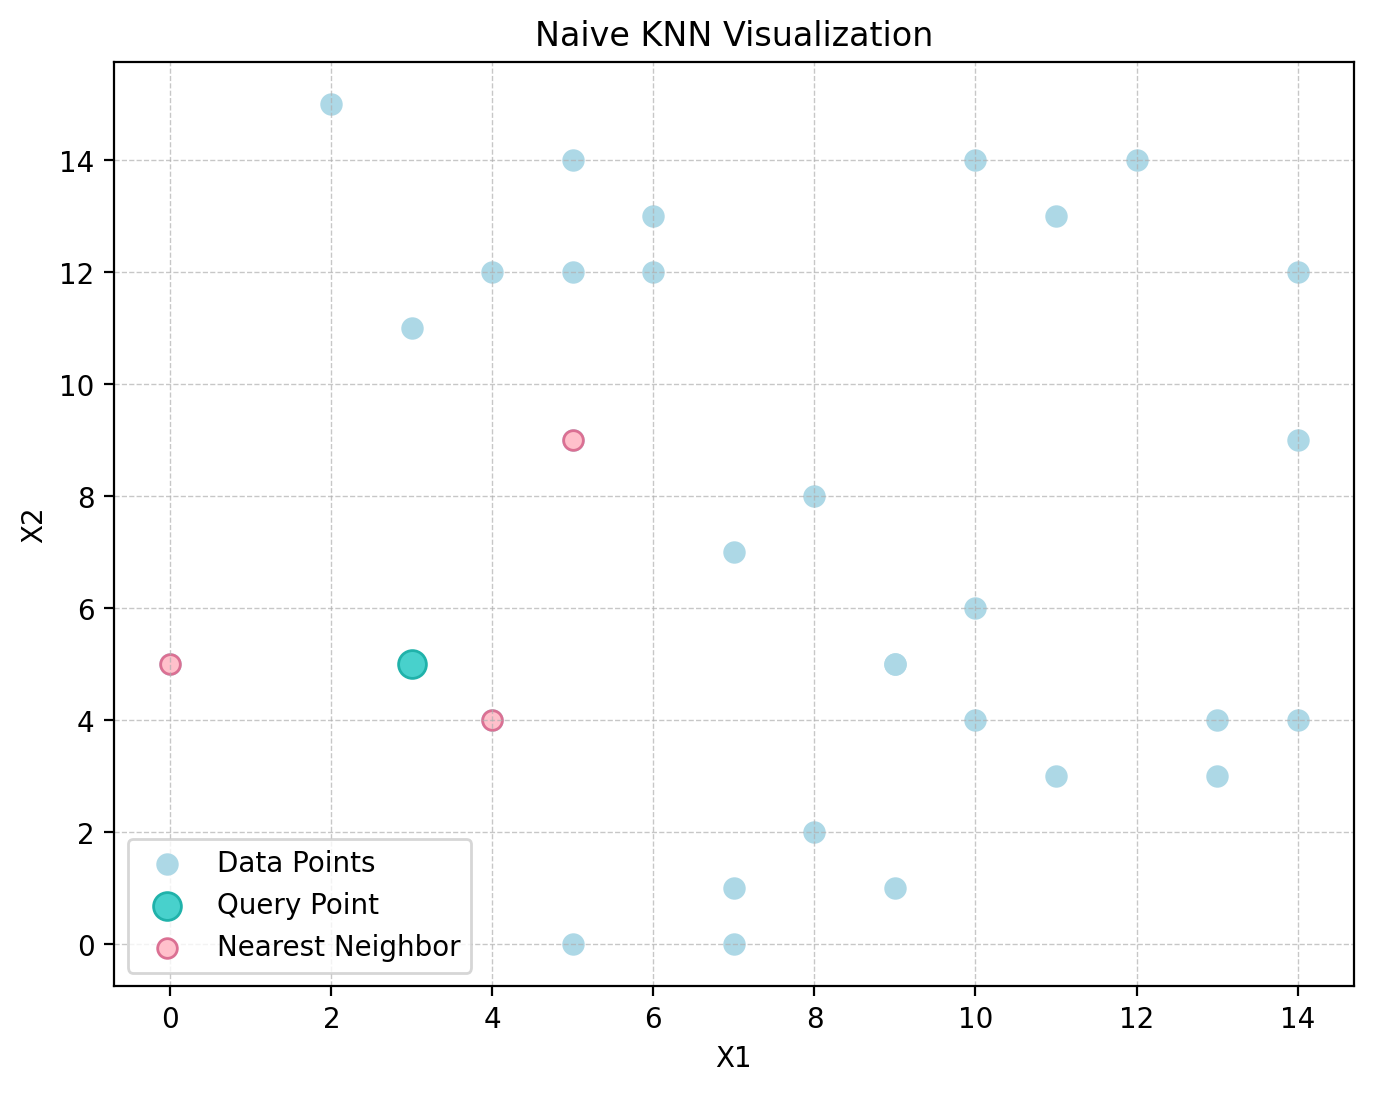

In [122]:
def plot_naive_knn(X_2d, query_point, dict_nn):
    query_key = tuple(map(float, query_point.flatten()))  # Ensure type consistency


    plt.figure(figsize=(8, 6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], s=50, color='lightblue', label='Data Points')
    plt.scatter(query_point[0][0], query_point[0][1], color='mediumturquoise', edgecolor='lightseagreen', s=100, label='Query Point')

    neighbors = dict_nn[query_key]
    for nn_point in neighbors.values():
        nn_point = np.array(nn_point)
        plt.scatter(nn_point[0], nn_point[1], color='pink', edgecolor='palevioletred', s=50, label='Nearest Neighbor')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title("Naive KNN Visualization")
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

plot_naive_knn(X_2d, query_point, dict_nn)


## LSH

In [ ]:
def plot_train_query_knn(X, y, query, knn, title, hp_2d):
  plt.figure(figsize=(8, 6))
  x_vals = np.linspace(-1, 16, 100)
  for w1, w2, b in hp_2d:
    if w2 != 0:  # to avoid division by zero
      slope = -w1 / w2
      intercept = -b / w2
      y_vals = slope * x_vals + intercept
      plt.plot(x_vals, y_vals, color='cyan', linestyle='--', linewidth=1, alpha = 0.6)  # hyperplane
    else:  # for vertical lines (w2 == 0)
      if w1 != 0:
        x_val = -b / w1
        plt.axvline(x=x_val, color='cyan', linestyle='--', linewidth=1, alpha = 0.6)  # hyperplane
  plt.xlim(0, 16)
  plt.ylim(0, 16)
  plt.title(title)
  plt.xlabel('X1')
  plt.ylabel('X2')
  plt.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=0.5) # gridlines
  scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50) # training points
  plt.scatter(X[knn, 0], X[knn, 1], c='pink', edgecolor='palevioletred', s=50, label='k-NN') # k nearest neighbours
  plt.scatter(query[0], query[1], c='mediumturquoise', edgecolor='lightseagreen', s=50, label='Query Point') # query point
  plt.colorbar(scatter, label='Continuous Labels')
  plt.legend()
  plt.show()

In [ ]:
L_2d = 4 # number of hyperplanes
y_2d, labels_2d, hp_2d, query_regions_2d, knn_list_2d = LSH(X_2d, [query_point], L_2d, k_2d)

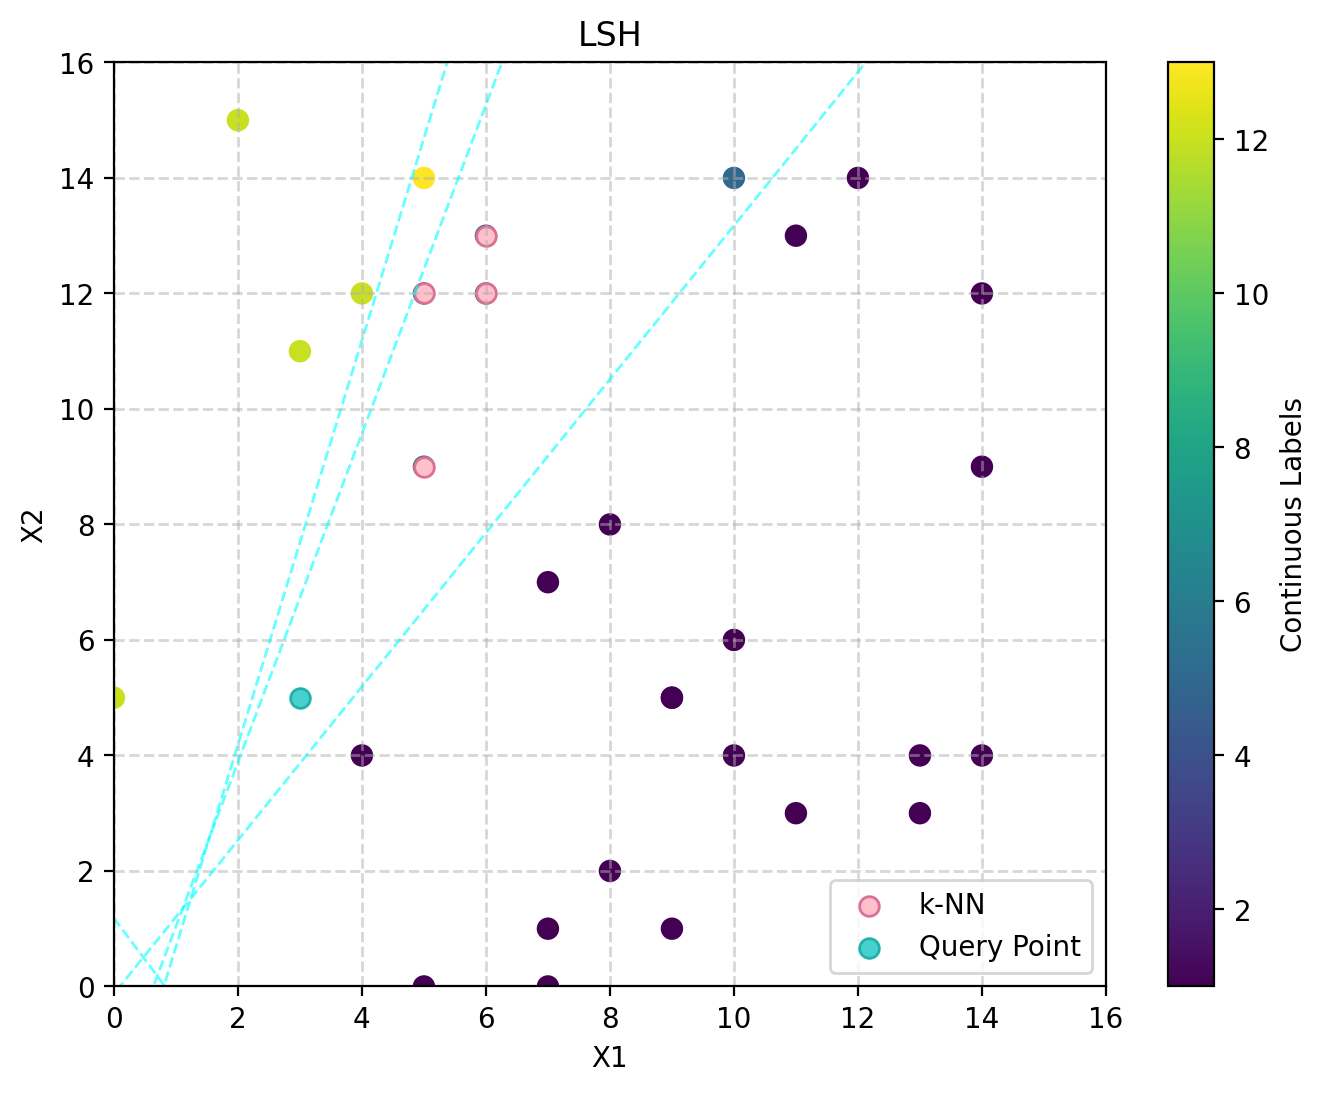

In [ ]:
plot_train_query_knn(X_2d, y_2d, query_point[0], knn_list_2d[0], "LSH", hp_2d)

##KD Trees

In [134]:
trained,medians_2d = pp_kdtree(X_2d,4)
d_nn_kd,times_kd = predict_kdtree(query_point,4,trained,medians_2d,4)

In [135]:
d_nn_kd

{(3, 5): {1.4142135623730951: array([4, 4]),
  3.0: array([0, 5]),
  5.385164807134504: array([5, 0])}}

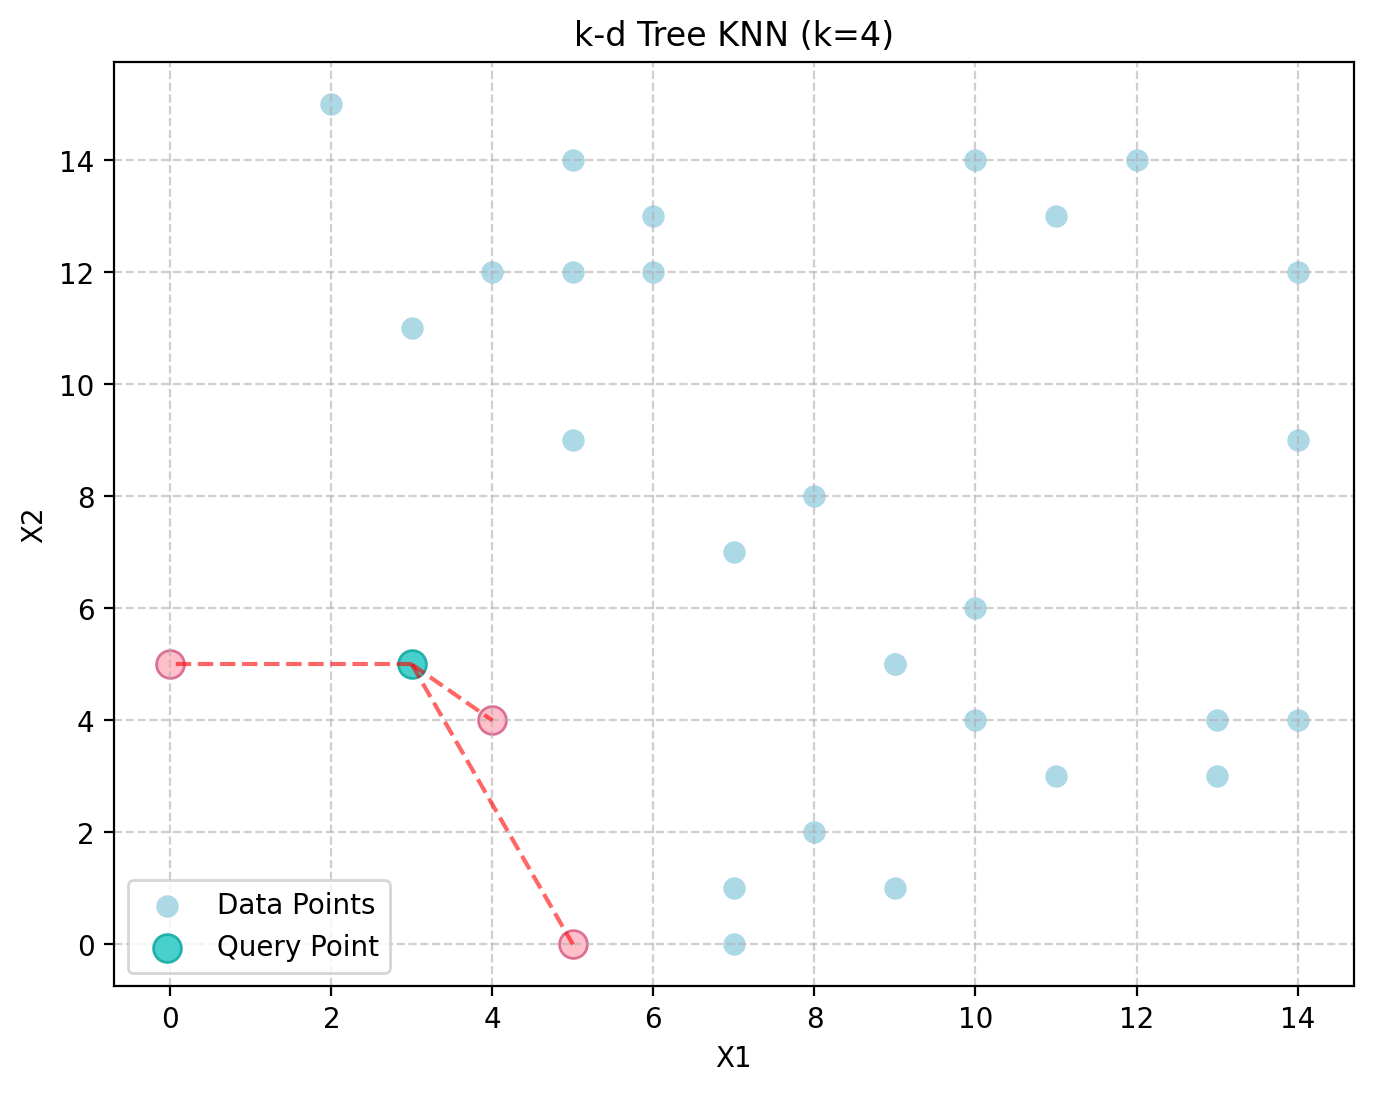

In [136]:
def plot_kdtree_knn(X_2d, query_point, d_nn_kd, k):
    query_key = tuple(query_point.flatten())
    if query_key not in d_nn_kd:
        raise KeyError(f"Query point {query_key} not found in d_nn_kd.")

    neighbors = d_nn_kd[query_key]

    plt.figure(figsize=(8, 6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], s=50, color='lightblue', label='Data Points')
    plt.scatter(query_point[0, 0], query_point[0, 1], color='mediumturquoise', edgecolor='lightseagreen', s=100, label='Query Point')

    for dist, nn_point in list(neighbors.items())[:k]:
        nn_point = np.array(nn_point)
        plt.scatter(nn_point[0], nn_point[1], color='pink', edgecolor='palevioletred', s=100)
        plt.plot([query_point[0, 0], nn_point[0]], [query_point[0, 1], nn_point[1]], 'r--', alpha=0.6)

    plt.title(f"k-d Tree KNN (k={k})")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


k = 4
plot_kdtree_knn(X_2d, query_point, d_nn_kd, k)
